In [2]:
import os
import json
import torch

os.chdir('../../')

/home/tsa87/anaconda3/envs/tacogfn/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import numpy as np
from rdkit import Chem
from matplotlib import pyplot as plt

In [4]:
pocket2mol_path = 'misc/evaluations/pocket2mol_agg_data_evaluated.json'
targetdiff_path = 'misc/evaluations/targetdiff_agg_data_evaluated.json'
decompdiff_path = 'misc/evaluations/decompdiff_beta_evaluated.json'

with open(pocket2mol_path, 'r') as f:
    pocket2mol = json.load(f)
    
with open(targetdiff_path, 'r') as f:
    targetdiff = json.load(f)
    
with open(decompdiff_path, 'r') as f:
    decompdiff = json.load(f)

In [5]:
pharmaco_res_path = 'misc/evaluations/A_0_100_crossdocked-mo-256-pocket-graph-1_evaluated.json'
with open(pharmaco_res_path) as f:
    pharmaco_res = json.load(f)

In [6]:
# get molecular weight
from rdkit.Chem.Descriptors import ExactMolWt

In [7]:
def get_top_10_lowest_scores_and_qed(data):
    scores = data['docking_scores']
    qeds = data['qeds']
    smiles = data['smiles']
    
    molecular_weights = [ExactMolWt(Chem.MolFromSmiles(s)) for s in smiles]
    
    # sort by index
    sort_idx = np.argsort(scores)
    sorted_scores = np.array(scores)[sort_idx]
    selected_mws = np.array(molecular_weights)[sort_idx]

    return np.mean(sorted_scores[:10]), np.mean(selected_mws[:10])


# FILEPATH: /home/tsa87/refactor-tacogfn/examples/figures/rank_by_ds.ipynb
med_vina = {
    key: get_top_10_lowest_scores_and_qed(v) for key, v in pharmaco_res.items() if key != '4iwq_A' # This one in DecompDiff is missing
}
sorted_med_vina = sorted(med_vina.items(), key=lambda x: x[1][0])

ordered_med_pocket2mol = [get_top_10_lowest_scores_and_qed(pocket2mol[key]) for key, _ in sorted_med_vina]
ordered_med_targetdiff = [get_top_10_lowest_scores_and_qed(targetdiff[key]) for key, _ in sorted_med_vina]
ordered_med_decompdiff = [get_top_10_lowest_scores_and_qed(decompdiff[key]) for key, _ in sorted_med_vina]

In [8]:
sort_key, sort_val = zip(*sorted_med_vina)

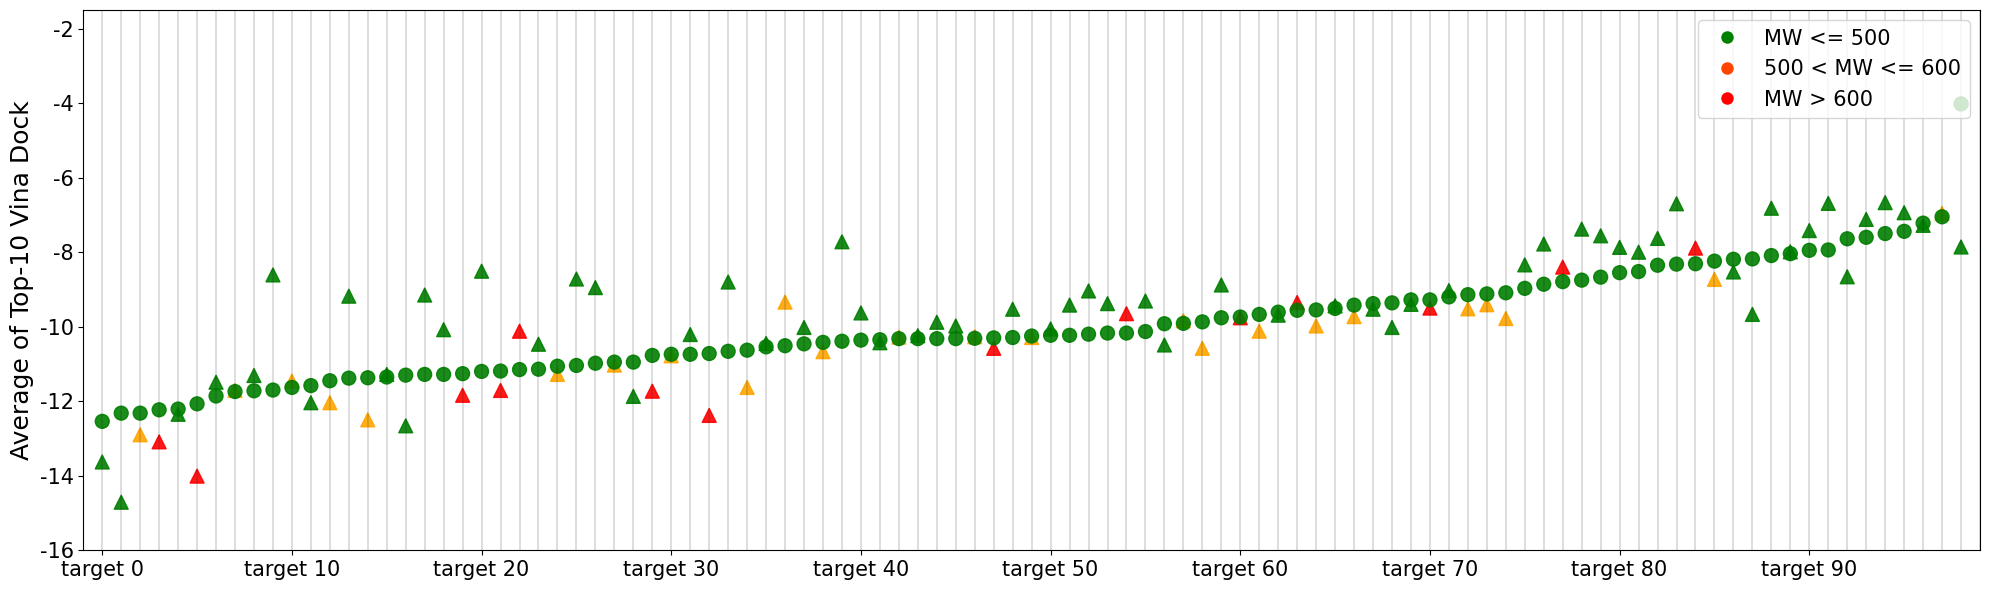

In [16]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors

best_vina_idx = []
for a, b in zip(sort_val, ordered_med_decompdiff):
    # find min of the 4 and append the index
    min_val = min(a[0], b[0])
    for idx, val in enumerate([a[0], b[0]]):
        if val == min_val:
            best_vina_idx.append(idx)
            break
best_vina_idx = np.array(best_vina_idx)


def map_color(value):
    if value <= 500:
        return 'green'
    elif 500 < value <= 600:
        return 'orange'
    else:
        return 'red'

# vmin = 350
# vmax = 750
# # Custom colormap: Red for 0, Green for 1
# colors = [(0, 1, 0, 1), (1, 0, 0, 1)]  # Red to Green
# n_bins = 100  # Use more bins for a smoother transition
# cmap = mcolors.LinearSegmentedColormap.from_list("custom_colormap", colors, N=n_bins)

fig, ax = plt.subplots(figsize=(20, 6), dpi=100)

avg_qed_taco = np.mean([v[1] for v in sort_val])
avg_qed_decomp = np.mean([v[1] for v in ordered_med_decompdiff])

decompdiff_color = [map_color(v[1]) for v in ordered_med_decompdiff]
tacogfn_color = [map_color(v[1]) for v in sort_val]

sc2 = ax.scatter(range(len(sort_val)), [v[0] for v in ordered_med_decompdiff], s=100, c=decompdiff_color, marker='^', label=f'DecompDiff (lowest in {np.mean(best_vina_idx==1)*100:.0f}%)', alpha=0.9) 
sc1= ax.scatter(range(len(sort_val)), [v[0] for v in sort_val], s=100, c=tacogfn_color, marker='o', label=f'TacoGFN (lowest in {np.mean(best_vina_idx==0)*100:.0f}%)', alpha=0.9)

# Increase font size of colorbar ticks
# cbar = plt.colorbar(sc1, ax=ax, pad=0.02)
# cbar.ax.tick_params(labelsize=15)
# cbar.set_label('Molecular Weights (Da)', fontsize=20)
# # show the average qed top right
# ax.text(0.9, 0.9, f'Average QED\nPharmacoGFN: {avg_qed_taco:.2f}\nDecompDiff: {avg_qed_decomp:.2f}', horizontalalignment='right', verticalalignment='top', transform=ax.transAxes, fontsize=20)

# Custom legend
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='green', markersize=10, label='MW <= 500'),
           plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='orangered', markersize=10, label='500 < MW <= 600'),
           plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='MW > 600')]

plt.legend(handles=handles, fontsize=15, loc='upper right')

plt.yticks(fontsize=15)
for i in range(100):
    plt.axvline(i, c='0.1', lw=0.2)

plt.xlim(-1, 99)
plt.ylim(-16, -1.5)
plt.yticks([-16, -14, -12, -10, -8, -6, -4, -2], [-16, -14, -12, -10, -8, -6, -4, -2], fontsize=15)
plt.ylabel('Average of Top-10 Vina Dock', fontsize=18)
plt.xticks(np.arange(0, 99, 10), [f'target {v}' for v in np.arange(0, 99, 10)], fontsize=15)

plt.tight_layout()
plt.savefig('figures/binding_mw.png', dpi=500, bbox_inches='tight')
plt.show()

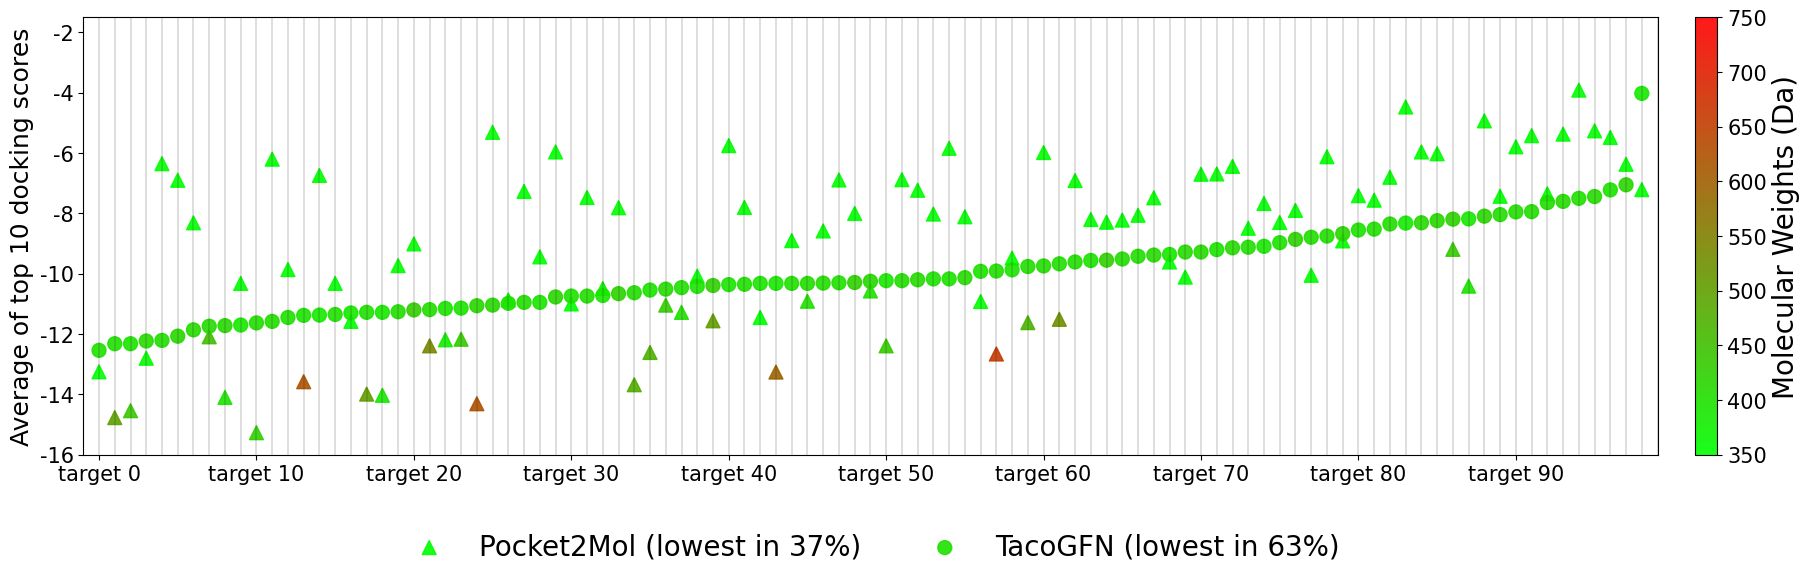

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors

best_vina_idx = []
for a, b in zip(sort_val, ordered_med_pocket2mol):
    # find min of the 4 and append the index
    min_val = min(a[0], b[0])
    for idx, val in enumerate([a[0], b[0]]):
        if val == min_val:
            best_vina_idx.append(idx)
            break
best_vina_idx = np.array(best_vina_idx)

vmin = 350
vmax = 750
# Custom colormap: Red for 0, Green for 1
colors = [(0, 1, 0, 1), (1, 0, 0, 1)]  # Red to Green
n_bins = 100  # Use more bins for a smoother transition
cmap = mcolors.LinearSegmentedColormap.from_list("custom_colormap", colors, N=n_bins)

fig, ax = plt.subplots(figsize=(20, 6), dpi=100)

avg_qed_taco = np.mean([v[1] for v in sort_val])
avg_qed_pocket2mol = np.mean([v[1] for v in ordered_med_pocket2mol])

sc2 = ax.scatter(range(len(sort_val)), [v[0] for v in ordered_med_pocket2mol], s=100, c=[v[1] for v in ordered_med_pocket2mol], marker='^', label=f'Pocket2Mol (lowest in {np.mean(best_vina_idx==1)*100:.0f}%)', vmin=vmin, vmax=vmax, cmap=cmap,alpha=0.9) 
sc1= ax.scatter(range(len(sort_val)), [v[0] for v in sort_val], s=100, c=[v[1] for v in sort_val], marker='o', label=f'TacoGFN (lowest in {np.mean(best_vina_idx==0)*100:.0f}%)', vmin=vmin, vmax=vmax, cmap=cmap, alpha=0.9)

# Increase font size of colorbar ticks
cbar = plt.colorbar(sc1, ax=ax, pad=0.02)
cbar.ax.tick_params(labelsize=15)
cbar.set_label('Molecular Weights (Da)', fontsize=20)
# # show the average qed top right
# ax.text(0.9, 0.9, f'Average QED\nPharmacoGFN: {avg_qed_taco:.2f}\nDecompDiff: {avg_qed_decomp:.2f}', horizontalalignment='right', verticalalignment='top', transform=ax.transAxes, fontsize=20)

plt.yticks(fontsize=15)
for i in range(100):
    plt.axvline(i, c='0.1', lw=0.2)

plt.xlim(-1, 99)
plt.ylim(-16, -1.5)
plt.yticks([-16, -14, -12, -10, -8, -6, -4, -2], [-16, -14, -12, -10, -8, -6, -4, -2], fontsize=15)
plt.ylabel('Average of top 10 docking scores', fontsize=18)
plt.legend(fontsize=20, loc='lower center', ncol=2, bbox_to_anchor=(0.5, -0.3), frameon=False)
plt.xticks(np.arange(0, 99, 10), [f'target {v}' for v in np.arange(0, 99, 10)], fontsize=15)

plt.tight_layout()
plt.savefig('figures/binding.png', dpi=500, bbox_inches='tight')
plt.show()

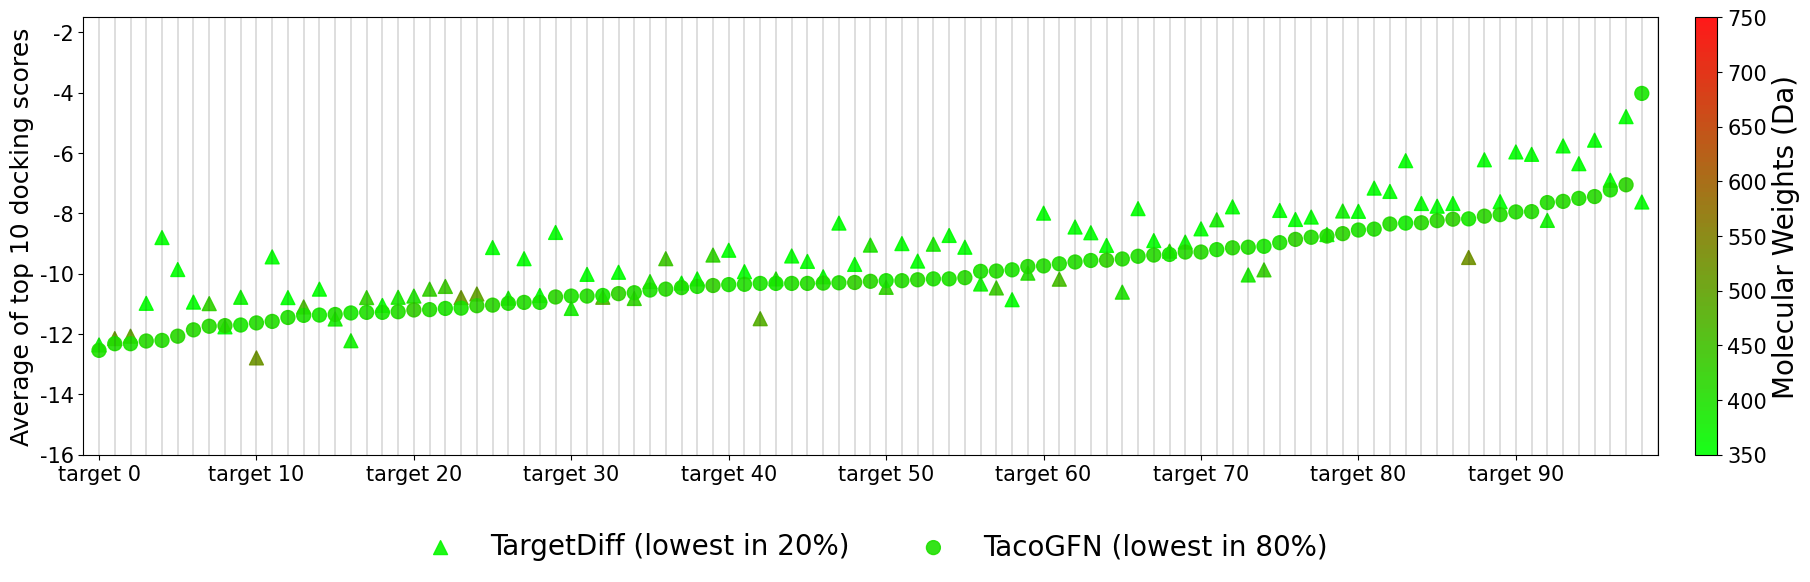

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors

best_vina_idx = []
for a, b in zip(sort_val, ordered_med_targetdiff):
    # find min of the 4 and append the index
    min_val = min(a[0], b[0])
    for idx, val in enumerate([a[0], b[0]]):
        if val == min_val:
            best_vina_idx.append(idx)
            break
best_vina_idx = np.array(best_vina_idx)

vmin = 350
vmax = 750
# Custom colormap: Red for 0, Green for 1
colors = [(0, 1, 0, 1), (1, 0, 0, 1)]  # Red to Green
n_bins = 100  # Use more bins for a smoother transition
cmap = mcolors.LinearSegmentedColormap.from_list("custom_colormap", colors, N=n_bins)

fig, ax = plt.subplots(figsize=(20, 6), dpi=100)

avg_qed_taco = np.mean([v[1] for v in sort_val])
avg_qed_targetdiff = np.mean([v[1] for v in ordered_med_targetdiff])

sc2 = ax.scatter(range(len(sort_val)), [v[0] for v in ordered_med_targetdiff], s=100, c=[v[1] for v in ordered_med_targetdiff], marker='^', label=f'TargetDiff (lowest in {np.mean(best_vina_idx==1)*100:.0f}%)', vmin=vmin, vmax=vmax, cmap=cmap,alpha=0.9) 
sc1= ax.scatter(range(len(sort_val)), [v[0] for v in sort_val], s=100, c=[v[1] for v in sort_val], marker='o', label=f'TacoGFN (lowest in {np.mean(best_vina_idx==0)*100:.0f}%)', vmin=vmin, vmax=vmax, cmap=cmap, alpha=0.9)

# Increase font size of colorbar ticks
cbar = plt.colorbar(sc1, ax=ax, pad=0.02)
cbar.ax.tick_params(labelsize=15)
cbar.set_label('Molecular Weights (Da)', fontsize=20)
# # show the average qed top right
# ax.text(0.9, 0.9, f'Average QED\nPharmacoGFN: {avg_qed_taco:.2f}\nDecompDiff: {avg_qed_decomp:.2f}', horizontalalignment='right', verticalalignment='top', transform=ax.transAxes, fontsize=20)

plt.yticks(fontsize=15)
for i in range(100):
    plt.axvline(i, c='0.1', lw=0.2)

plt.xlim(-1, 99)
plt.ylim(-16, -1.5)
plt.yticks([-16, -14, -12, -10, -8, -6, -4, -2], [-16, -14, -12, -10, -8, -6, -4, -2], fontsize=15)
plt.ylabel('Average of top 10 docking scores', fontsize=18)
plt.legend(fontsize=20, loc='lower center', ncol=2, bbox_to_anchor=(0.5, -0.3), frameon=False)
plt.xticks(np.arange(0, 99, 10), [f'target {v}' for v in np.arange(0, 99, 10)], fontsize=15)

plt.tight_layout()
plt.savefig('figures/binding.png', dpi=500, bbox_inches='tight')
plt.show()